# Neural networks and logistic regression
## Lecture objectives

1. Demonstrate how to estimate neural network models
2. Demonstrate how to estimate logistic regression models
3. Provide more practice with train-test splits and assessing model performance
4. Show how to standardize data

In the previous video lectures, we estimated a random forests model using `scikit-learn`. 

Here, we'll explore other machine learning algorithms.

Most have almost identical syntax, meaning once you are familiar with one model it's easy to apply another model. However, they will have different hyperparameters, such as the number of trees in the random forest.

To start with, let's do the following:
* load the data we previous saved as a pickle
* recreate the dummy variables
* create a dataframe with the subset of variables that we want to use, and drop the NaNs

In [1]:
# this is the same code as from the previous lecture
import pandas as pd
joinedDf = pd.read_pickle('../scratch/joined_permits.pandas')

dummies1 = pd.get_dummies(joinedDf.UseType, prefix='usetype_')  # creates a dataframe of dummies
dummies2 = pd.get_dummies(joinedDf.UseDescription, prefix='usedesc_')
joinedDf = joinedDf.join(dummies1).join(dummies2) 

xvars = (dummies1.columns.tolist() + dummies2.columns.tolist() + 
            ['YearBuilt1', 'Units1', 'Bedrooms1', 'Bathrooms1', 'SQFTmain1', 
             'Roll_LandValue', 'Roll_ImpValue', 'Roll_LandBaseYear', 
             'Roll_ImpBaseYear', 'CENTER_LAT', 'CENTER_LON' ])
yvar = 'hasADU'

# create a dataframe with no NaNs
df_to_fit = joinedDf[xvars+[yvar]].dropna()

Let's also import the relevant `scikit-learn` functions.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

## Standardizing data
Many machine learning algorithms are more robust if we *standardize* the data - subtract the mean and divide by the standard deviation. This puts each variable on a common scale.

It didn't matter for random forests, but it does for neural networks.

Let's do this. Note that we need to exclude the dummy variable columns and the dependent variable.

To identify them, we'll use a Python [list comprehension](https://www.w3schools.com/python/python_lists_comprehension.asp). 

In [3]:
# Example: add a suffix to each column
oldcols = ['units', 'squarefeet','lotsize']
newcols = []
for col in oldcols:
    newcols.append(col+'_2020')
print(newcols)

['units_2020', 'squarefeet_2020', 'lotsize_2020']


In [4]:
# This is much cleaner as a list comprehension
[col+'_2020' for col in oldcols]

['units_2020', 'squarefeet_2020', 'lotsize_2020']

In [5]:
[col+'_2020' for col in oldcols if 'units' not in col]

['squarefeet_2020', 'lotsize_2020']

In [6]:
cols_to_exclude = [col for col in df_to_fit.columns 
                if col.startswith('usetype_') or col.startswith('usedesc_') 
                or col=='hasADU']

<div class="alert alert-block alert-info">
    <strong>Exercise:</strong> How would you rewrite this list comprehension as a <strong>for</strong> loop?
</div>

In [7]:
cols_to_exclude = []
for col in df_to_fit.columns:
    if col.startswith('usetype_') or col.startswith('usedesc_') or col=='hasADU':
        cols_to_exclude.append(col)

Now let's create a list of the columns that we *don't* want to exclude. 

We can use a list comprehension again: we'll include that column in the new list if the condition (`col not in cols_to_exclude`) is `True`.

In [8]:
otherCols = [col for col in df_to_fit.columns if col not in cols_to_exclude]
otherCols

['YearBuilt1',
 'Units1',
 'Bedrooms1',
 'Bathrooms1',
 'SQFTmain1',
 'Roll_LandValue',
 'Roll_ImpValue',
 'Roll_LandBaseYear',
 'Roll_ImpBaseYear',
 'CENTER_LAT',
 'CENTER_LON']

Now let's scale `otherCols`. Note that the `StandardScaler` returns a numpy array, not a pandas DataFrame. So we need to convert the array to a dataframe and specify the column names and the index.

In [9]:
# see https://scikit-learn.org/stable/modules/preprocessing.html for standardization
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(df_to_fit[otherCols])

# convert to DataFrame and specify the column names and index
df_scaled = pd.DataFrame(scaler.transform(df_to_fit[otherCols]), 
                         columns=otherCols, index=df_to_fit.index)

# create a DataFrame with these scaled columns joined to the columns that we didn't scale
df_scaled = df_scaled.join(df_to_fit[cols_to_exclude])

df_scaled.head()

,YearBuilt1,Units1,Bedrooms1,Bathrooms1,SQFTmain1,Roll_LandValue,Roll_ImpValue,Roll_LandBaseYear,Roll_ImpBaseYear,CENTER_LAT,...,usedesc__Theaters,usedesc__Three Units (Any Combination),usedesc__Timber-Pine,usedesc__Two Units,usedesc__Utility Commercial & Mutual: Pumping Plants State Assessed Pr,usedesc__Vineyards,"usedesc__Warehousing, Distribution, Storage",usedesc__Water Recreation,usedesc__Wholesale & Manufacturing Outlets,hasADU
APN,,,,,,,,,,,,,,,,,,,,,
2004-001-003,0.200922,-0.09917,0.106676,0.043894,-0.070366,0.110462,-0.026365,0.189152,0.166185,1.018125,...,0,0,0,0,0,0,0,0,0,False
2004-001-004,0.200922,-0.09917,0.302178,0.043894,-0.041227,-0.099975,-0.035412,0.415242,0.373153,1.016651,...,0,0,0,0,0,0,0,0,0,False
2004-001-005,0.200922,-0.09917,0.106676,-0.148365,-0.072838,-0.003857,-0.046856,0.867420,0.787091,1.015171,...,0,0,0,0,0,0,0,0,0,False
2004-001-008,0.234672,-0.09917,0.106676,0.043894,-0.045422,-0.249323,-0.042185,-1.280428,-1.179111,1.019055,...,0,0,0,0,0,0,0,0,0,False
2004-001-009,0.234672,-0.09917,0.106676,0.043894,-0.060179,-0.242222,-0.044572,-1.054339,-0.972142,1.018964,...,0,0,0,0,0,0,0,0,0,False


<div class="alert alert-block alert-info">
    <strong>Exercise:</strong> Verify that the standardization works (each column should have mean zero and standard deviation one).
</div>

In [10]:
df_scaled.describe()

,YearBuilt1,Units1,Bedrooms1,Bathrooms1,SQFTmain1,Roll_LandValue,Roll_ImpValue,Roll_LandBaseYear,Roll_ImpBaseYear,CENTER_LAT,...,usedesc__Supermarkets,usedesc__Theaters,usedesc__Three Units (Any Combination),usedesc__Timber-Pine,usedesc__Two Units,usedesc__Utility Commercial & Mutual: Pumping Plants State Assessed Pr,usedesc__Vineyards,"usedesc__Warehousing, Distribution, Storage",usedesc__Water Recreation,usedesc__Wholesale & Manufacturing Outlets
count,7.774850e+05,7.774850e+05,7.774850e+05,7.774850e+05,7.774850e+05,7.774850e+05,7.774850e+05,7.774850e+05,7.774850e+05,7.774850e+05,...,777485.000000,777485.000000,777485.000000,777485.0,777485.000000,777485.000000,777485.0,777485.000000,777485.000000,777485.000000
mean,-5.553581e-16,-1.769308e-17,-4.861942e-17,4.869254e-17,-1.710819e-17,-3.158435e-17,-2.120246e-18,-3.606757e-15,2.341336e-15,-5.034311e-14,...,0.000324,0.000089,0.022412,0.0,0.068859,0.000040,0.0,0.004097,0.000001,0.000192
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,0.018000,0.009420,0.148019,0.0,0.253215,0.006314,0.0,0.063873,0.001134,0.013842
min,-1.311646e+01,-2.209371e-01,-6.753328e-01,-5.328834e-01,-2.269242e-01,-3.285389e-01,-8.651547e-02,-1.131946e+02,-1.036286e+02,-3.173150e+00,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,-4.882070e-02,-9.917034e-02,-2.843283e-01,-3.406242e-01,-1.392069e-01,-2.512988e-01,-6.588306e-02,-6.021602e-01,-5.064631e-01,-6.162655e-01,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,6.592615e-02,-9.917034e-02,-8.882611e-02,-1.483651e-01,-1.087943e-01,-1.567389e-01,-5.150684e-02,1.326300e-01,1.144427e-01,-3.988048e-02,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
75%,1.874228e-01,-9.917034e-02,1.066761e-01,4.389404e-02,-4.999151e-02,6.913180e-03,-2.630315e-02,7.543755e-01,6.836063e-01,8.090708e-01,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
max,5.316633e-01,1.214241e+02,1.867939e+01,1.850077e+01,1.663685e+02,1.528883e+02,1.896980e+02,1.093509e+00,1.045801e+00,4.354188e+00,...,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.0,1.000000,1.000000,1.000000


We'll do our train/test split as before.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
      df_scaled[xvars], df_scaled[yvar], test_size = 0.25, random_state = 1)

And estimate our neural network model. 

Note that the workflow and syntax is very similar to the random forests:
* Initialize the classifier object - here, we call it `mlp`
* Fit to the data
* Predict

In [12]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

How did we do?

In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.97      1.00      0.98    188165
        True       0.70      0.02      0.03      6207

    accuracy                           0.97    194372
   macro avg       0.83      0.51      0.51    194372
weighted avg       0.96      0.97      0.95    194372



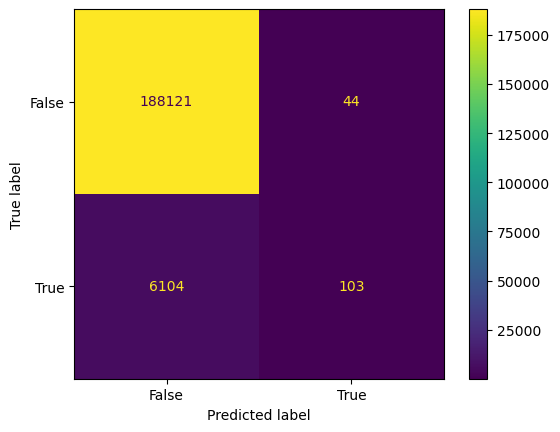

In [14]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

Interestingly, we get very similar results to the random forests. Perhaps this indicates the inherent unpredictability of ADUs, given how rarely they are constructed. Or we might be able to do better with additional predictors or through adjusting the hyperparameters.

## Logistic regression
As a point of comparison, how would a more traditional logistic regression fare?

Many different regression estimators are implemented in `scikit-learn`. And the syntax should be familiar by now. Note that standardization (as we did for neural networks) helps.



In [15]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Note that it doesn't even converge! Methods like logistic regression don't handle highly correlated variables very well.

We might be able to do better with a smaller set of predictors.

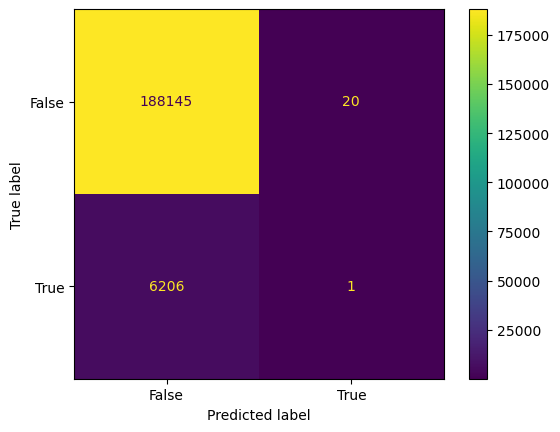

In [16]:
xvars = ['YearBuilt1', 'Units1', 'Bedrooms1', 'Bathrooms1', 'SQFTmain1', 'Roll_LandValue', 
             'Roll_ImpValue', 'Roll_LandBaseYear', 'Roll_ImpBaseYear', 'CENTER_LAT', 'CENTER_LON', 'usedesc__Single']

lr = LogisticRegression()
lr.fit(X_train[xvars], y_train)
y_pred = lr.predict(X_test[xvars])
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

Not so great, eh? So our random forests and neural networks approaches look much better by comparison.

<div class="alert alert-block alert-info">
<h3>Key Takeaways</h3>
<ul>
  <li>There are several different approaches to machine learning. Random forests and neural networks are two of the most popular.</li>
  <li>scikit-learn provides a consistent syntax: initialize-fit-predict. So once you've done one ML model, others are much simpler.</li>
</ul>
</div>